In [1]:
import os
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_STATE = 42
NOISE_LEVEL = 0.10

MODELS_DIR = '../models/'
IMBALANCED_DATA_PATH = '../data/01_raw/original_imbalanced.csv'
SMOTE_DATA_PATH = '../data/02_processed/smote_augmented_train.csv'
MODEL_DRIVEN_SYNTHETIC_PATH = '../data/02_processed/model_driven_synthetic.csv'

h2o.init(nthreads=-1, max_mem_size="10g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-17.0.16+8 (build 17.0.16+8, mixed mode, sharing)
  Starting server from C:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\bharg\AppData\Local\Temp\tmp38nvbfoz
  JVM stdout: C:\Users\bharg\AppData\Local\Temp\tmp38nvbfoz\h2o_bharg_started_from_python.out
  JVM stderr: C:\Users\bharg\AppData\Local\Temp\tmp38nvbfoz\h2o_bharg_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 6 days
H2O_cluster_name:,H2O_from_python_bharg_iuwod8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


# Model Loading and Training

In [3]:
def get_trained_model(model_name, training_hf, predictors, response, sort_metric="AUCPR"):
    """Loads a saved H2O model or retains it if not found"""
    model_path = os.path.join(MODELS_DIR, f"{model_name}.model")

    if os.path.exists(model_path):
        print(f"Loading saved model: {model_name}...")
        model = h2o.load_model(model_path)
    else:
        print(f"Training and saving model: {model_name}...")
        if len(training_hf.split_frame(ratios=[0.8], seed=RANDOM_STATE)) == 2:
            train, valid = training_hf.split_frame(ratios=[0.8], seed=RANDOM_STATE)
            validation_frame = valid
        else:
            train = training_hf
            validation_frame = None
        
        aml = H2OAutoML(
            max_runtime_secs=600,
            max_models=20,
            seed=RANDOM_STATE,
            project_name=f"{model_name}_train", 
            sort_metric=sort_metric
        )
        aml.train(x=predictors, y=response, training_frame=train, validation_frame=validation_frame)
        model = aml.leader
        h2o.save_model(model=model, path=MODELS_DIR, filename=f"{model_name}.model", force=True)

    return model

In [4]:
# Prepare data and get models
response = "target"

# Model 1
hf_imbalanced = h2o.H2OFrame(pd.read_csv(IMBALANCED_DATA_PATH))
hf_imbalanced[response] = hf_imbalanced[response].asfactor()
predictors = [c for c in hf_imbalanced.columns if c != response]
model_imbalanced = get_trained_model("imbalanced_leader", hf_imbalanced, predictors, response)

# Model 2
df_smote_train = pd.read_csv(SMOTE_DATA_PATH)
hf_smote_train = h2o.H2OFrame(df_smote_train)
hf_smote_train[response] = hf_smote_train[response].asfactor()
smote_predictors = [c for c in hf_smote_train.columns if c != response]
model_smote = get_trained_model("smote_leader", hf_smote_train, smote_predictors, response)

# Model 3
hf_model_driven = h2o.H2OFrame(pd.read_csv(MODEL_DRIVEN_SYNTHETIC_PATH))
hf_model_driven[response] = hf_model_driven[response].asfactor()
model_model_driven = get_trained_model("model_driven_leader", hf_model_driven, predictors, response)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Loading saved model: imbalanced_leader...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Loading saved model: smote_leader...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Loading saved model: model_driven_leader...


# Test Set Preparation (Clean vs. Noisy)

In [5]:
_, _, test_hf_clean = hf_imbalanced.split_frame(ratios=[0.7, 0.15], seed=RANDOM_STATE)

print("\nCreating pertubed (noisy) test set...")
df_test_clean = test_hf_clean.as_data_frame()
df_test_noisy = df_test_clean.copy()

numerical_cols = df_test_noisy.select_dtypes(include=np.number).columns.drop(response, errors='ignore')

for col in numerical_cols:
    std = df_test_noisy[col].std()
    noise = np.random.normal(0, std * NOISE_LEVEL, df_test_noisy.shape[0])
    df_test_noisy[col] = df_test_noisy[col] + noise

test_hf_noisy = h2o.H2OFrame(df_test_noisy)
test_hf_noisy[response] = test_hf_noisy[response].asfactor()

print("Test sets prepared")



Creating pertubed (noisy) test set...


c:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test sets prepared


# Evaluation and analysis

In [ ]:
def evaluate_model(model, test_hf, model_name, dataset_type, one_hot_predictors=None, response="target"):
    """Helper function to evaluate a model and return key metrics"""
    if one_hot_predictors:
        test_df = test_hf.as_data_frame()
        test_df_encoded = pd.get_dummies(test_df)
        test_df_encoded = test_df_encoded.reindex(columns=one_hot_predictors + [response], fill_value=0)
        test_hf_eval = h2o.H2OFrame(test_df_encoded)
        test_hf_eval[response] = test_hf_eval[response].asfactor()
    else:
        test_hf_eval = test_hf
    
    perf = model.model_performance(test_hf_eval)
    return {
        "Model": model_name,
        "Test Set": dataset_type,
        "AUPRC": perf.aucpr(),
        "F1": perf.F1()[0][1],
        "AUC": perf.auc()
    }

all_results = []
models_to_test = {
    "Imbalanced": model_imbalanced,
    "SMOTE": model_smote,
    "ModelDriven": model_model_driven
}

for name, model in models_to_test.items():
    print(f"Evaluating {name} model...")
    smote_preds = smote_predictors if name == "SMOTE" else None
    
    all_results.append(evaluate_model(model, test_hf_clean, name, "Clean", smote_preds))
    all_results.append(evaluate_model(model, test_hf_noisy, name, "Noisy", smote_preds))

#  Analyse Results 
df_results = pd.DataFrame(all_results)
df_pivot = df_results.pivot(index="Model", columns="Test Set", values=["AUPRC", "F1"])

Evaluating Imbalanced model...
Evaluating SMOTE model...


c:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


c:\Project\Synthetic Intelligence\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Evaluating ModelDriven model...


In [7]:
df_pivot = df_pivot.reset_index()

# Compute drop metrics
df_pivot['AUPRC_Drop'] = (df_pivot[('AUPRC', "Clean")] - df_pivot[('AUPRC', 'Noisy')]) / df_pivot[('AUPRC', 'Clean')]
df_pivot['F1_Drop'] = (df_pivot[('F1', 'Clean')] - df_pivot[('F1', "Noisy")]) / df_pivot[('F1', 'Clean')]

print("\n\n Robustness Performance Comparison")
print(df_pivot.round(4))




 Robustness Performance Comparison
                Model   AUPRC              F1         AUPRC_Drop F1_Drop
Test Set                Clean   Noisy   Clean   Noisy                   
0          Imbalanced  0.7511  0.7515  0.8146  0.8150    -0.0005 -0.0006
1         ModelDriven  0.6809  0.6728  0.7165  0.7074     0.0119  0.0127
2               SMOTE  0.9301  0.9218  0.8602  0.8561     0.0089  0.0048


In [8]:
print(df_pivot.columns)
print(df_pivot.head())


MultiIndex([(     'Model',      ''),
            (     'AUPRC', 'Clean'),
            (     'AUPRC', 'Noisy'),
            (        'F1', 'Clean'),
            (        'F1', 'Noisy'),
            ('AUPRC_Drop',      ''),
            (   'F1_Drop',      '')],
           names=[None, 'Test Set'])
                Model     AUPRC                  F1           AUPRC_Drop  \
Test Set                  Clean     Noisy     Clean     Noisy              
0          Imbalanced  0.751116  0.751486  0.814562  0.815022  -0.000493   
1         ModelDriven  0.680857  0.672775  0.716453  0.707373   0.011871   
2               SMOTE  0.930105  0.921836  0.860215  0.856084   0.008891   

           F1_Drop  
Test Set            
0        -0.000565  
1         0.012673  
2         0.004802  


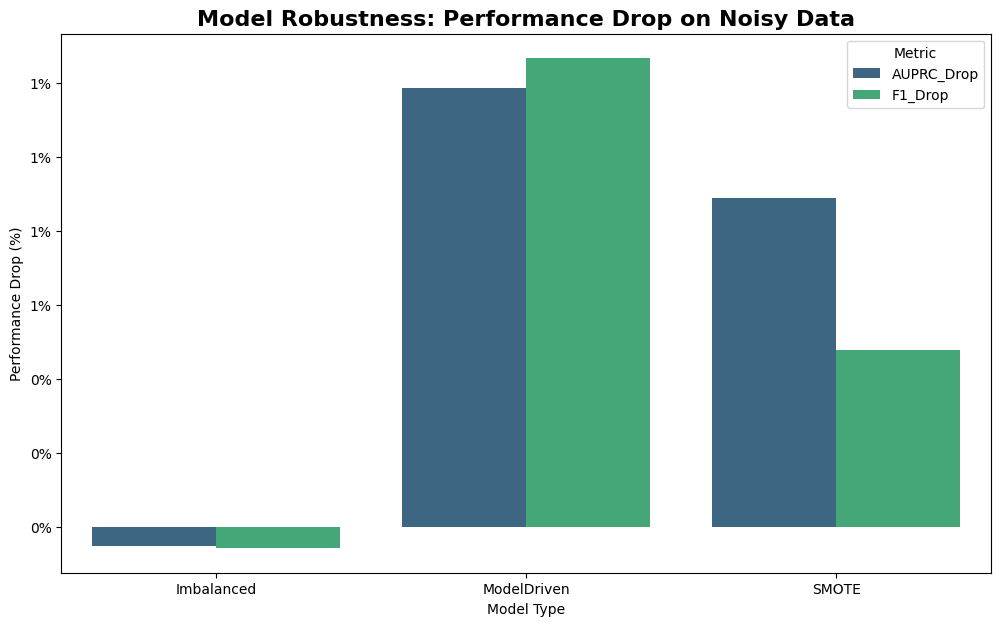

In [ ]:
# Flatten MultiIndex columns
df_pivot.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0] 
    for col in df_pivot.columns
]

# Melt for plotting
df_plot = df_pivot.melt(
    id_vars='Model',
    value_vars=['AUPRC_Drop', 'F1_Drop'],
    var_name='Metric',
    value_name='Performance Drop'
)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Performance Drop', hue='Metric', data=df_plot, palette='viridis')
plt.title('Model Robustness: Performance Drop on Noisy Data', fontsize=16, fontweight='bold')
plt.ylabel('Performance Drop (%)')
plt.xlabel('Model Type')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()



In [16]:
h2o.cluster().shutdown()


H2O session _sid_bd3c closed.
